# Notebook Version of Biological Age Code

In [3]:
"""BIOLOGICAL AGE ALGORITHM
NOTE: RUN IN ANACONDA FOR PYTHON 2.7 ONLY

How to use commands:
- Create an instance of the data, then apply methods.
	- e.g. To find means, use Summary(dataset).mean()

Classes:
Summary:
	Methods: 
	.mean() [calculates mean]
	.corr(col1, col2) [calculates Pearson's Corr Coefficient & p-value] *col2 can be a list or one column. Both parameters are OPTIONAL
	.view [shows data as a dataframe]
Methods:
	Methods:
	.KDM() [gives Klemera & Doubal equation for biological age]
	.cleandata(col1,col2) [gets rid of all rows with missing values]
	.calcLR() [calculates linear regressions of all vars with age as predictor]
Visualize:
	.plot(X,Y,[stratifying_variable]) [view plot of biological age vs chronological age]
	.view [analyze data frame output]

"""

"BIOLOGICAL AGE ALGORITHM\nNOTE: RUN IN ANACONDA FOR PYTHON 2.7 ONLY\n\nHow to use commands:\n- Create an instance of the data, then apply methods.\n\t- e.g. To find means, use Summary(dataset).mean()\n\nClasses:\nSummary:\n\tMethods: \n\t.mean() [calculates mean]\n\t.corr(col1, col2) [calculates Pearson's Corr Coefficient & p-value] *col2 can be a list or one column. Both parameters are OPTIONAL\n\t.view [shows data as a dataframe]\nMethods:\n\tMethods:\n\t.KDM() [gives Klemera & Doubal equation for biological age]\n\t.cleandata(col1,col2) [gets rid of all rows with missing values]\n\t.calcLR() [calculates linear regressions of all vars with age as predictor]\nVisualize:\n\t.plot(X,Y,[stratifying_variable]) [view plot of biological age vs chronological age]\n\t.view [analyze data frame output]\n\n"

In [4]:
from numpy import mean, corrcoef, array
import math
from scipy import stats
from sklearn import datasets, linear_model
#import statsmodels.api as sm
import pandas as ps
import ggplot as gg
import json
import matplotlib.pyplot as plt
import numpy as np

/anaconda3/envs/python2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


### Global Variables

In [5]:
#GLOBAL VARS
age = 8 #define the column 'age' for clarity
primarykey = 0  #SEQN or other primary identifier
genderindex = 12 #define the column for gender (should be binary)
samp_wt = 9
AGEON = True # age corrector toggle
GRAPHON = True # do you want to see linear regression graphs for each variable on age?

### Open Data

In [6]:
#OPEN DATA

############# EDIT HERE ###############
path = 'BioAgeSample_NHANESIII_2019_3070.txt' #2019_3069 #without_fvc
delimiter = '\t'
#######################################

fhnd = open(path,'r')
data = []
CACHE_FNAME = 'projectcache.txt' #create a cache for parameters dictionary to save time

#FORMAT DATA
for line in fhnd:
    linelist = line.strip().split(delimiter)
    data.append(linelist)

for line in data[1:]:
    for i in range(len(line)):
        try:
            line[i] = float(line[i])
        except:
            pass

fhnd.close()

In [7]:
################## CLASS SUMMARY #######################

#Double check means
#Make a dictionary of the means of each thing, turn into a function
class Summary(object):
    def __init__(self,data):
        self.data = data
        self.view = ps.DataFrame(self.data[1:],columns=self.data[0])

    def mean(self, lowerboundage=30, upperboundage=75):
        avgdict = {}
        floatdum = 3.0
        # cols 0 - 16
        for col in range(len(self.data[0])):
            avglist = []
            sampwtlist = []

            for line in self.data:
                if line[age] >= lowerboundage and line[age] <= upperboundage and type(line[col]) == type(floatdum):
                    avglist.append(line[col])
                    sampwtlist.append(line[samp_wt])

            avgdict[self.data[0][col]] = mean(avglist) #sum([i * j for i,j in zip(avglist, sampwtlist)])/len(avglist)

        self.make_pretty(avgdict,"MEANS:")
        return avgdict

    #returns a pretty row of results
    def make_pretty(self,dictionary,titlestring):
        print "\n" + titlestring
        keylist = sorted(dictionary.keys())
        for key in keylist:
            if len(key) < 8 :
                print key + '\t\t' + str(dictionary[key])
            else:
                print key + '\t' + str(dictionary[key])

    def __str__(self):
        return "There are {} observations and {} variables in this dataset.".format(len(self.data),len(self.data[0]))

    #returns the Pearson Correlation coefficient of each row in the dataset to a variable
    #input parameters: column number of you want to compare to. Second one to compare to
    #first value can only be one value. If you put a #<0 for y, will be a list of all vals. default is all vals
    def corr(self, x=age, y=-1):
        corrdict = {}
        repeat = False
        #establishes what we'll be correlating to x
        if y >= 0:
            collist = [y]
        elif y < 0:
            collist = range(len(self.data[0]))
        else:
            print "Please enter a valid input"
            quit()

        for col in collist:
            corrlistx = []
            corrlisty= []
            for line in self.data:
                if type(line[x]) == type(1.2):
                    corrlistx.append(line[x])
                elif type(line[x]) != type(1.2):
                    corrlistx.append('.')

                if type(line[col]) == type(1.2):
                    corrlisty.append(line[col])
                else:
                    corrlisty.append('.')

            try:
                corrdict[self.data[0][col]] = stats.pearsonr(*self.findmissing(corrlistx,corrlisty))
            except:
                print "Cannot perfom correlation on", self.data[0][col]

        self.make_pretty(corrdict,"CORRELATIONS: (r, p-value)")
        return corrdict

    #throws away values where at least one value is missing
    def findmissing(self,corrlist1,corrlist2):
        for i in range(len(corrlist1)):
            try:
                if corrlist1[i] != type(1.2):
                    del corrlist1[i]
                    del corrlist2[i]
            except: pass

        for i in range(len(corrlist2)):
            try:
                if corrlist2[i] != type(1.2):
                    del corrlist1[i]
                    del corrlist2[i]
            except: pass
        return (corrlist1, corrlist2)

In [8]:

################## CLASS METHODS #######################
class Methods(object):
    def __init__(self,data):
        self.data = data
        print("Looking for data in cache...")
        try:
            cache_fhnd = open(CACHE_FNAME,'r')
            self.CACHE_DICT = json.loads(cache_fhnd.read())
            cache_fhnd.close()
        except:
            self.CACHE_DICT = {}


### Klemera and Doubal Method ###

#Note on CACHE_DICT vs cachedict: CACHE_DICT is the "global local" variable for the instance. cachedict is input as a parameter if the value is in CACHE_DICT
    def KDM(self):
        #have this one combine the two datasets, for men and for women
        #and append to a list
        finaldict = {}

        for sex in [1,0]:
            if sex == 0:
                sexname = "Males"
            else: sexname = "Females"

            if str(sex) in self.CACHE_DICT:
                print("Collecting parameters from cache for %s..." % (sexname))
                self.calcLR(sex=sex,cachedict = self.CACHE_DICT[str(sex)]) #finds self.regressiondict and makes self.newdata
                finaldict[sex] = self.calcBA(correctiondict = self.correctionterm(self.calcBA()))
            else:
                print("Could not find parameters in the cache for %s..." % (sexname))
                self.calcLR(sex=sex) #makes self.regressiondict
                finaldict[sex] = self.calcBA(correctiondict = self.correctionterm(self.calcBA()))

        print("Merging data one last time...")
        #Double check this...
        for row in self.data:
            for sexkey in finaldict: #going through each SEQN
                for key in finaldict[sexkey]:
                    if key == row[primarykey]:          #if you found the right SEQN for that row, append the Corrected Biological Age to the end
                        row.append(finaldict[sexkey][key])
        if 'BA' not in self.data[0]:
            self.data[0].append('BA')
        if 'BAC' not in self.data[0]:
            self.data[0].append('BAC')

        print("DONE!")

        path = 'test2.csv'
        fopen = open(path,'w+')
        
        print("Saving Data...")
        for row in self.data:
            for i in range(len(row)):
                row[i] = str(row[i])
            fopen.write(",".join(row) + "\n")

    #   fopen.write(json.dumps(finaldict))
        fopen.close()
        print("DONE!")
        return self.data

    #REMEMBER TO CONSIDER SEX IN THIS...CALCLR CALCULATES FOR ONLY ONE SEX AT A TIME BUT YOU NEED A DICTIONARY THAT ACCOUNTS FOR BOTH
    #this uses the regression results to create all the baseline variables for KDM calculations
    def correctionterm(self, datatuple, agemax = 75, agemin = 30):
        m = datatuple[1] #this tells you how many covariates we have
        BAdict = datatuple[0] #this was BasicBAdict from the calcBA function
        n = len(self.newdata)-1
        delcounter = 0

        CorrectedBAdict = {}
        
        #Merge BAdict with self.newdata (remember, this is the dataset with only one sex)
        print("Merging data...")
        for row in self.newdata[1:]:
            try:
                row.append(BAdict[row[primarykey]][0]) #will append to the end of the row the BA value from the dictionary, using the primary key as the identifier
            except:
                del(row)
                delcounter += 1

        if delcounter > 0: 
            print("Warning: %d rows deleted. Check the integrity of the data or check the code." % (delcounter))

        #STANDARD DEVIATION CALCULATIONS
        #Calculating first term
        errcalc  = []
        print("Calculating Correction Term...")
        for row in self.newdata[1:]:
            BA = row[-1] #the last value appended to each row
            errcalc.append(BA - row[age])
        errcalc = np.array(errcalc)
        #Calculating standard deviation

        for row in self.newdata[1:]:
            rchar = BAdict[row[primarykey]][1]
            stderr = (np.var(errcalc) - (((1-(rchar**2))/(rchar**2)) * (((agemax - agemin)**2)/(12*m))))
            
            # Extra step: Linearly transform so that SBA maintains same mean but now linearly increases with age, so difference is 5 between CAmax and CAmin
            if AGEON == True:
                agecorrector = 5/(agemax-agemin)
                std = np.sqrt(stderr) - 2.5 + (agecorrector * row[age]) # adjust based on age
                stderr = std ** 2
                #print(stderr)

            CorrectedBAdict[row[primarykey]] = stderr

        return CorrectedBAdict
    #############
    def cov(self, x, y, w):
        """Weighted Covariance"""
        return np.sum(w * (x - np.average(x, weights = w)) * (y - np.average(y, weights = w))) / np.sum(w)

    def corr(self, x, y, w):
        """Weighted Correlation"""
        return self.cov(x, y, w) / np.sqrt(self.cov(x, x, w) * self.cov(y, y, w))
    #############

    #This takes all the data from the Linear Regression function and calcuates the baseline predicted age and rchar.
    #It then passes all the variables to correctionterm method (if you use the .KDM() method), which will aggregate these variables into calculating the corrected BA.
    def calcBA(self, correctiondict={}):
        #append another value to the end of each row?
        BasicBAdict = {}
        CorrectedBAdict = {}

        if correctiondict == {}:
            print("Calculating initial BA without Correction...")
            for row in self.newdata[1:]:
                numeratorlist = []
                denominatorlist = []
                rcharlistnumerator = []
                rcharlistdenominator = []
            #append BA data to each row
                for key in self.regressiondict:
                #append numerators to a list and denominators to a list, then sum and divide
                    covar = self.regressiondict[key] #references one column or variable in study
                    k = covar[0] #slope
                    s = covar[3] #MSE
                    q = covar[1] #intercept
                    r = covar[2] #r-value
                    colindex = self.newdata[0].index(key) #find the column of the data

                    try:
                        numeratorlist.append((row[colindex]-q)*(k/(s**2)))
                        denominatorlist.append((k/s)**2)
                        rcharlistnumerator.append(((r**2)/(math.sqrt(1-(r**2)))))
                        rcharlistdenominator.append((r/(math.sqrt(1-(r**2)))))
                    except:
                        print("r:",r, "var:", key)
                        print(self.regressiondict)
                        quit()
                #rcalculations
                rchar = sum(rcharlistnumerator)/sum(rcharlistdenominator)
                #create a dictionary with SEQN as key

                BasicBAdict[row[primarykey]] = (sum(numeratorlist)/sum(denominatorlist), rchar)
            #returns a tuple with dictionary first, m second
            return (BasicBAdict,len(self.regressiondict))
        else:
            print("Calculating final Age with Corrected Values...")
            for row in self.newdata[1:]:
                numeratorlist = []
                denominatorlist = []

                #append BA data to each row
                for key in self.regressiondict:
                #append numerators to a list and denominators to a list, then sum and divide
                    covar = self.regressiondict[key] #references one column or variable in study
                    k = covar[0] #slope
                    s = covar[3] #MSE
                    q = covar[1] #intercept
                    r = covar[2] #r-value
                    colindex = self.newdata[0].index(key) #find the column of the data

                    numeratorlist.append((row[colindex]-q)*(k/(s**2))+(row[age]/correctiondict[row[primarykey]]))
                    denominatorlist.append(((k/s)**2)+(1/correctiondict[row[primarykey]]))

                #create a dictionary with SEQN as key
                CorrectedBAdict[row[primarykey]] = sum(numeratorlist)/sum(denominatorlist)
            #returns a final dictionary of Corrected BA
            return CorrectedBAdict



    #remember female = 1, means female
    #this does the inital linear regressions: MODEL xx = age
    def calcLR(self, sex=0, cachedict = {}):
        #creates a new dataset for ONLY females or only males
        self.newdata = [line for line in self.data if line[genderindex] == "female" or line[genderindex] == sex]
        self.df = ps.DataFrame(self.newdata[1:],columns=data[0])
        self.heading = self.newdata[0]
        self.regressiondict = {} #saves tuple: (slope,intercept,r_value,std_err)
        if sex == 0:
            sexname = "Males"
        else:
            sexname = "Females"
        #check if there is already a value in cachedict:
        if cachedict == {}:
            print("Calculating regressions for %s..." % (sexname))
        

            # REGRESSION PART #
            for col in self.heading:
                #print col
                regX = np.array(self.df[['age']]) #age
                regY = np.array(self.df[[col]]) #other var

                regr = linear_model.LinearRegression()
                # slope, intercept, r_value, p_value, std_err = stats.linregress(x,y) TRY THIS
                try:
                # Train the model using the training sets
                    weight = np.array(self.get_column(9)).reshape(len(self.get_column(9)),1)
                    regr.fit(regX,regY,sample_weight=self.get_column(9))
                    #print regr.get_params(deep=False)

                    #The coefficients
                    #print 'Coefficients: \n', regr.coef_
                    #print 'Intercept: \n', regr.intercept_
        
                    # The mean squared error
                    #print "Mean squared error: %.2f" % mean((regr.predict(regX) - regY) ** 2) #MSE
                    # Explained variance score: 1 is perfect prediction
                    #print 'Variance score: %.2f' % (regr.score(regX, regY)) #variance
                    #need slope, intercept, r-value

                    # Plot outputs
                    if GRAPHON == True:
                        plt.scatter(regX, regY,  color='black')
                        plt.plot(regX, regr.predict(regX), color='blue', linewidth=3)
                        plt.xticks(())
                        plt.yticks(())
                        plt.title('%s vs Age' % (col))
                        plt.xlabel('age')
                        plt.ylabel(col)
                        plt.show()

                    #do linear regressions analysis
                    slope = regr.coef_[0][0]
                    intercept = regr.intercept_[0]
                    # weighted vs unweighted corr seems to make no difference
                    r_value = self.corr(regX, regY, weight) #stats.pearsonr(regX,regY)[0][0]
                    std_err = math.sqrt(mean((regr.predict(regX) - regY) ** 2))
                    #print slope, intercept, r_value, std_err

                except:
                    print("Cannot do LINEAR REGRESSION analysis for %s" % (col))
                    slope = 0
                    intercept = 0
                    r_value = 0
                    std_err = 0

                #CHECK THAT ONLY PROPER VALUES ARE ADDED
                if slope and intercept and r_value and std_err != 0 and col != 'age' and col != 'seqn' and col != 'female' and col != 'samp_wt':
                    #add to dictionaries
                    self.regressiondict[col] = (slope, intercept, r_value, std_err)



            #add to cache
            cache_fhnd = open(CACHE_FNAME,'w')
            self.CACHE_DICT[str(sex)] = self.regressiondict
            cache_fhnd.write(json.dumps(self.CACHE_DICT))
            cache_fhnd.close()
        #if there is, make it into self.regressiondict
        else:
            self.regressiondict = cachedict
        self.make_pretty(self.regressiondict,"REGRESSION VALUES (slope, intercept, r_value, std_err)")
        return self.regressiondict


### Utility Functions ###

    #returns the mean of each row in the dataset
    def make_pretty(self,dictionary,titlestring):
        print("\n" + titlestring)
        keylist = sorted(dictionary.keys())
        for key in keylist:
            if len(key) < 8 :
                print key + '\t\t' + str(dictionary[key])
            else:
                print key + '\t' + str(dictionary[key])

    #extracts one column from the dataset
    def get_column(self,col):
        column = [line[col] for line in self.newdata]
        return column[1:]

    #throws away values where at least one value is missing
    def cleandata(self,col1,col2):
        for i in range(len(col1)):
            try:
                if col1[i] != type(1.2):
                    del col1[i]
                    del col2[i]
            except: pass

        for i in range(len(col2)):
            try:
                if col2[i] != type(1.2):
                    del col1[i]
                    del col2[i]
            except: pass
        if len(col1) == len(col2):
        #   print "Dimensions match for both columns"
            return (col1, col2)
        else:
            print("Cannot match data by length, check data dimensions.")
            return (len(col1), len(col2))

In [9]:
class Visualize(object):
    def __init__(self,data):
        self.data = ps.DataFrame(data[1:],columns=data[0])

    def view(self):
        return self.data

    def plot(self, inp1, inp2, inp3=None):
        p = gg.ggplot(gg.aes(x=inp1, y=inp2, color=inp3), data=self.data) + \
        gg.geom_point()

        print(p)


## Run Code

In [12]:
b = Methods(data)
results = b.KDM()

Looking for data in cache...

REGRESSION VALUES (slope, intercept, r_value, std_err)
amp		[-0.0033146564817593577, 4.236146883993196, -0.12726121106518468, 0.35035342164900674]
appsi		[0.6532795266915864, 48.7040625510915, 0.28172231489382404, 32.44328176693714]
bup		[0.1335648675268825, 7.02848844796384, 0.3719756491175875, 4.733213434477145]
cep		[0.0031710591293707536, 0.8175042832078918, 0.17019696189786956, 0.35794959738665105]
cmvod		[0.02186762053249976, 0.8962358207108343, 0.24156363659410038, 1.0308846215933596]
crp		[0.005603573494426509, 0.20751613761405635, 0.10387034687873857, 0.9408648835513247]
fev		[-32.674667134760014, 4179.144340821564, -0.6471791634584438, 497.9824795226481]
fev_fvc		[-0.002553072330743134, 0.9033690918751776, -0.38200964647872976, 0.07961428539054893]
fvc		[-31.73102599211728, 4855.78229777554, -0.5601359423088407, 624.0062962191604]
ghp		[0.023305404685565207, 4.275135664648143, 0.290468688837507, 1.2474551998341727]
sbp		[0.8089268383651086, 82.24

## View Results

In [22]:
#FORMAT DATA (makes it easier to plot)
for line in results[1:]:
    for i in range(len(line)):
        try:
            line[i] = float(line[i])
        except:
            pass

In [23]:
c = Visualize(results)
c.view()

,seqn,bup,tcp,crp,cep,appsi,amp,ghp,age,samp_wt,cmvod,fev,female,wbc,sbp,fvc,fev_fvc,BA,BAC
0,4.0,11.0,160.0,0.21,0.7,89.0,4.1,4.6,32.0,0.183278,0.517,3089.0,1.0,12.55,126.0,3536.0,0.873586,33.102727,32.107276
1,9.0,14.0,236.0,0.21,0.8,59.0,4.0,5.3,48.0,2.066707,1.946,2512.0,1.0,4.95,131.0,3436.0,0.731083,52.391256,48.427192
2,10.0,14.0,225.0,0.21,1.2,74.0,4.5,4.6,35.0,2.950445,0.349,3911.0,0.0,5.9,130.0,4630.0,0.844708,36.607949,35.160278
3,19.0,10.0,187.0,0.21,1.1,86.0,4.2,5.7,44.0,0.410218,3.001,2594.0,0.0,6.1,133.0,4080.0,0.635784,67.560946,46.348518
4,34.0,15.0,216.0,0.21,0.8,84.0,3.9,5.5,42.0,0.534605,3.001,2331.0,1.0,5.05,100.0,2850.0,0.817895,50.785393,42.854665
5,48.0,10.0,156.0,1.54,1.0,69.0,3.7,5.0,56.0,2.860106,3.001,2478.0,1.0,8.85,128.0,3375.0,0.734222,48.970407,55.316144
6,51.0,15.0,162.0,0.21,1.2,91.0,4.5,5.5,44.0,0.290115,3.001,3445.0,0.0,7,130.0,4283.0,0.804343,50.041880,44.602245
7,52.0,11.0,244.0,0.21,1.2,67.0,4.3,5.9,50.0,0.148594,2.509,4658.0,0.0,6.85,117.0,5514.0,0.844759,29.472378,47.953839
8,55.0,13.0,212.0,0.21,1.0,84.0,4.5,5.7,48.0,0.085426,2.417,3960.0,0.0,7.45,155.0,4629.0,0.855476,46.117295,47.812335
9,63.0,14.0,202.0,0.44,1.0,79.0,3.5,6.2,66.0,0.527590,3.001,1903.0,1.0,6.6,137.0,2487.0,0.765179,66.994303,66.096728


### Visualize

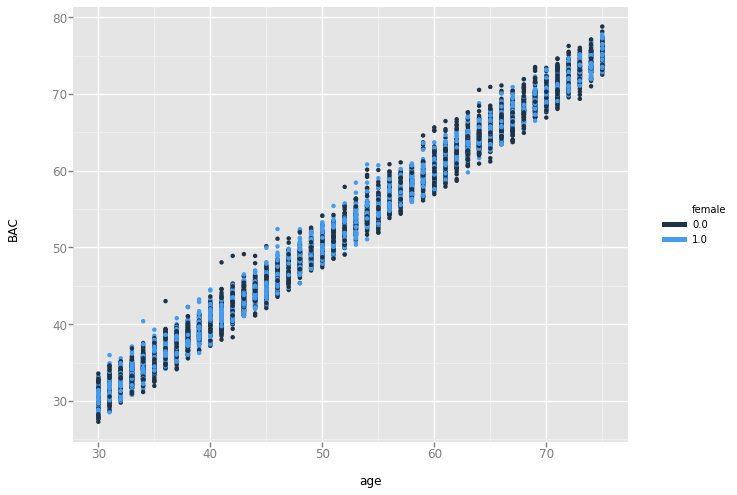

<ggplot: (7559906261)>


In [24]:
c.plot('age','BAC','female')

### Summarize

In [25]:
a = Summary(data)
a.mean(30,70)


MEANS:
BA		50.942168855006365
BAC		47.86078715109231
age		47.52455174030236
amp		4.128454234138052
appsi		86.22360248447205
bup		13.92851283253252
cep		1.0724598586663543
cmvod		2.087315560658971
crp		0.49080627656510023
female		0.5353334114613852
fev		2954.318059299191
fev_fvc		0.7796167517332709
fvc		3793.0619946091642
ghp		5.624469705601781
samp_wt		1.2701492500717213
sbp		125.12762217274113
seqn		27843.670338685104
tcp		210.02531348880817
wbc		7.191123101861955


{'BA': 50.942168855006365,
 'BAC': 47.86078715109231,
 'age': 47.52455174030236,
 'amp': 4.128454234138052,
 'appsi': 86.22360248447205,
 'bup': 13.92851283253252,
 'cep': 1.0724598586663543,
 'cmvod': 2.087315560658971,
 'crp': 0.49080627656510023,
 'female': 0.5353334114613852,
 'fev': 2954.318059299191,
 'fev_fvc': 0.7796167517332709,
 'fvc': 3793.0619946091642,
 'ghp': 5.624469705601781,
 'samp_wt': 1.2701492500717213,
 'sbp': 125.12762217274113,
 'seqn': 27843.670338685104,
 'tcp': 210.02531348880817,
 'wbc': 7.191123101861955}

In [26]:
print(a)

There are 9302 observations and 19 variables in this dataset.


In [27]:
a.corr()

Cannot perfom correlation on wbc

CORRELATIONS: (r, p-value)
BA		(0.7130149649769709, 0.0)
BAC		(0.995751552977933, 0.0)
age		(1.0, 0.0)
amp		(-0.17270002422616804, 5.0339760283972197e-17)
appsi		(0.15880904331366585, 1.3363415690136657e-14)
bup		(0.3172050898753924, 1.6651503390769705e-55)
cep		(0.1555323294815273, 4.649553770048036e-14)
cmvod		(0.23868253354530825, 1.7771924641457272e-31)
crp		(0.09611277563997449, 3.4397005971293316e-06)
female		(-0.029735255135260236, 0.1517641344061881)
fev		(-0.5157423491017133, 3.3010388069004153e-158)
fev_fvc		(-0.4372739322360667, 3.3846944852336116e-109)
fvc		(-0.3744977132543299, 2.6207912882988625e-78)
ghp		(0.2300573196552747, 2.651374466524648e-29)
samp_wt		(-0.16899563040832352, 2.3375841338431526e-16)
sbp		(0.4913527386758101, 1.391574462528332e-141)
seqn		(-0.01104548707798113, 0.5945016645581351)
tcp		(0.29576082177405344, 3.7204830101480135e-48)


{'BA': (0.7130149649769709, 0.0),
 'BAC': (0.995751552977933, 0.0),
 'age': (1.0, 0.0),
 'amp': (-0.17270002422616804, 5.0339760283972197e-17),
 'appsi': (0.15880904331366585, 1.3363415690136657e-14),
 'bup': (0.3172050898753924, 1.6651503390769705e-55),
 'cep': (0.1555323294815273, 4.649553770048036e-14),
 'cmvod': (0.23868253354530825, 1.7771924641457272e-31),
 'crp': (0.09611277563997449, 3.4397005971293316e-06),
 'female': (-0.029735255135260236, 0.1517641344061881),
 'fev': (-0.5157423491017133, 3.3010388069004153e-158),
 'fev_fvc': (-0.4372739322360667, 3.3846944852336116e-109),
 'fvc': (-0.3744977132543299, 2.6207912882988625e-78),
 'ghp': (0.2300573196552747, 2.651374466524648e-29),
 'samp_wt': (-0.16899563040832352, 2.3375841338431526e-16),
 'sbp': (0.4913527386758101, 1.391574462528332e-141),
 'seqn': (-0.01104548707798113, 0.5945016645581351),
 'tcp': (0.29576082177405344, 3.7204830101480135e-48)}